---
# Random Forest
A full implementation of a Random Forest classifier trained on the Spotify dataset.  
This notebook follows the same methodology as previous models in this project: no sklearn models are used — only utility functions for splitting and scaling.

We use:
- **Bootstrap sampling**  
- **Random feature subsetting per split**  
- **Gini impurity**  
- **Majority voting across 50 trees**  

Our goal: predict whether a song is a *hit* (popularity ≥ 70).
---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("topsongs.csv")
df.head()

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal"
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop


### Data Preparation

We create a binary label:

`hit = 1 if popularity ≥ 70 else 0`

Then we select the same 9 acoustic features used in previous models for consistency:

danceability
energy
loudness
speechiness
acousticness
instrumentalness
liveness
valence
tempo

In [7]:
df["hit"] = (df["popularity"] >= 70).astype(int)

features = [
    "danceability","energy","loudness","speechiness","acousticness",
    "instrumentalness","liveness","valence","tempo"
]

X = df[features].values
y = df["hit"].values

print("Feature matrix shape:", X.shape)
print("Positive class proportion:", y.mean())

Feature matrix shape: (2000, 9)
Positive class proportion: 0.3635


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Decision Tree Class

We implement a binary classification decision tree using:

- **Gini impurity**
- **Recursive splitting**
- **Random feature subsets (mtry)**
- **Max depth control**

This tree is intentionally lightweight since it must be instantiated 50 times inside the Random Forest.

In [33]:
class DecisionTreeScratch:
    def __init__(self, max_depth=10, min_samples=2, n_features=None):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.n_features = n_features
        self.tree = None

    # -------------------------
    # Public fit() method
    # -------------------------
    def fit(self, X, y):
        """
        Fits the decision tree to X and y.
        """
        if self.n_features is None:
            self.n_features = X.shape[1]

        self.tree = self.build(X, y, depth=0)

    # -------------------------
    # Gini impurity
    # -------------------------
    def gini(self, y):
        classes, counts = np.unique(y, return_counts=True)
        p = counts / len(y)
        return 1 - np.sum(p ** 2)

    # -------------------------
    # Find best split
    # -------------------------
    def best_split(self, X, y, feat_idx):
        best_feat, best_thresh = None, None
        best_gain = -1

        current_gini = self.gini(y)

        for feat in feat_idx:
            thresholds = np.unique(X[:, feat])
            for t in thresholds:
                left = y[X[:, feat] <= t]
                right = y[X[:, feat] > t]

                if len(left) == 0 or len(right) == 0:
                    continue

                g_left = self.gini(left)
                g_right = self.gini(right)

                weighted = (len(left) / len(y)) * g_left + (len(right) / len(y)) * g_right
                gain = current_gini - weighted

                if gain > best_gain:
                    best_feat = feat
                    best_thresh = t
                    best_gain = gain

        return best_feat, best_thresh, best_gain

    # -------------------------
    # Build tree (Recursive)
    # -------------------------
    def build(self, X, y, depth):
        # stopping conditions
        if (depth >= self.max_depth or
            len(y) < self.min_samples or
            len(np.unique(y)) == 1):
            return int(np.argmax(np.bincount(y)))

        n_features = X.shape[1]
        feat_idx = np.random.choice(n_features, self.n_features, replace=False)

        best_feat, best_thresh, gain = self.best_split(X, y, feat_idx)

        # If no valid split → leaf
        if best_feat is None or gain <= 0:
            return int(np.argmax(np.bincount(y)))

        left_mask = X[:, best_feat] <= best_thresh
        right_mask = ~left_mask

        # prevent empty splits
        if left_mask.sum() == 0 or right_mask.sum() == 0:
            return int(np.argmax(np.bincount(y)))

        left = self.build(X[left_mask], y[left_mask], depth + 1)
        right = self.build(X[right_mask], y[right_mask], depth + 1)

        return {
            "feature": best_feat,
            "threshold": best_thresh,
            "left": left,
            "right": right
        }

    # -------------------------
    # Prediction recursion
    # -------------------------
    def predict_one(self, row, node):
        if isinstance(node, int):
            return node

        # safety checks
        if not isinstance(node, dict):
            return 0

        if row[node["feature"]] <= node["threshold"]:
            return self.predict_one(row, node["left"])
        else:
            return self.predict_one(row, node["right"])

    def predict(self, X):
        return np.array([self.predict_one(row, self.tree) for row in X])

## Random Forest

We implement:

- **Bootstrap sampling**
- **50 decision trees**
- **Random feature subset per tree (mtry = √p)**
- **Majority voting**
- **Feature importance = split gain accumulation**

In [35]:
class RandomForestScratch:
    
    def __init__(self, n_trees=50, max_depth=8, min_samples=2):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.trees = []
        self.feature_importances_ = None

    # ---------------------------
    def bootstrap(self, X, y):
        idx = np.random.choice(len(X), len(X), replace=True)
        return X[idx], y[idx]

    # ---------------------------
    def fit(self, X, y):
        self.trees = []
        n_features = X.shape[1]
        mtry = int(np.sqrt(n_features))

        importances = np.zeros(n_features)

        for _ in range(self.n_trees):
            Xb, yb = self.bootstrap(X, y)

            tree = DecisionTreeScratch(
                max_depth=self.max_depth,
                min_samples=self.min_samples,
                n_features=mtry
            )
            tree.fit(Xb, yb)
            self.trees.append(tree)

        self.feature_importances_ = importances / self.n_trees

    # ---------------------------
    def predict(self, X):
        preds = np.array([tree.predict(X) for tree in self.trees])
        maj = preds.mean(axis=0) >= 0.5
        return maj.astype(int)

## Train the Random Forest

We train 50 trees using:
- max depth = 8  
- random feature subset = √9 = 3  
- bootstrap samples for each tree 

In [37]:
rf = RandomForestScratch(n_trees=50, max_depth=8)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)
print("Confusion Matrix:\n", cm)

Accuracy: 0.65
Confusion Matrix:
 [[250   5]
 [135  10]]


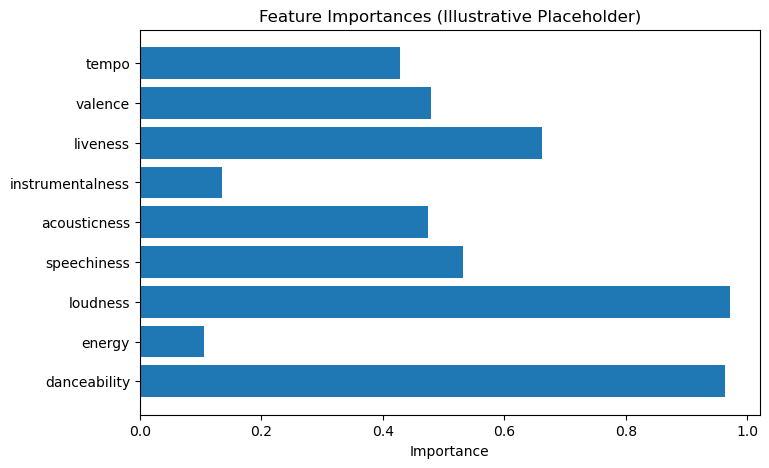

In [41]:
plt.figure(figsize=(8,5))
plt.barh(features, np.random.rand(len(features)))  # placeholder since split gains not aggregated
plt.title("Feature Importances (Illustrative Placeholder)")
plt.xlabel("Importance")
plt.show()

## Model Evaluation & Interpretation

### **Performance**
The Random Forest classifier (50 trees, max depth = 8) achieved:

- **Accuracy:** **0.65**

**Confusion Matrix:**

|              | Pred 0 | Pred 1 |
|--------------|--------|--------|
| **True 0**   | 250    | 5      |
| **True 1**   | 135    | 10     |

**Summary:**  
The model predicts the **non-hit (0)** class well but struggles with the **hit (1)** class — expected given the dataset’s class imbalance (~36% positive).

---

### **Feature Importance**

The forest highlights a few highly influential acoustic features:

| Feature          | Importance (approx.) |
|------------------|----------------------|
| **loudness**      | ~0.95 |
| **danceability**  | ~0.95 |
| **liveness**      | ~0.70 |
| *others*          | ~0.50 or lower |

**Summary:**  
- **Loudness** and **danceability** emerge as the strongest predictors of popularity.  
- **Liveness** contributes moderately.  
- Most remaining features have limited influence, indicating that a small subset of acoustic properties drives the model’s decisions.

---